In [1]:
import os
os.chdir('/home/featurize/work/mmsegmentation')
print(os.getcwd())  # 查看当前路径

/home/featurize/work/mmsegmentation


In [2]:
os.getcwd()

'/home/featurize/work/mmsegmentation'

## 导入工具包

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import cv2

## 载入模型：deeplabV3+

In [5]:
# 模型 config 配置文件
config_file = 'My-Configs/windowdataset_DeepLabV3plus_20250403.py'

# 模型 checkpoint 权重文件
checkpoint_file = 'checkpoint/windeeplab.pth'

# device = 'cpu'
device = 'cuda:0'

model = init_model(config_file, checkpoint_file, device=device)

Loads checkpoint by local backend from path: checkpoint/windeeplab.pth


## 载入模型：Fast-SCNN

In [116]:
# # 模型 config 配置文件
# config_file = 'My-Configs/windowdataset_FastSCNN_20250403.py'

# # 模型 checkpoint 权重文件
# checkpoint_file = 'checkpoint/winFastSCNN.pth'

# # device = 'cpu'
# device = 'cuda:0'

# model = init_model(config_file, checkpoint_file, device=device)

Loads checkpoint by local backend from path: checkpoint/winFastSCNN.pth


## 载入测试集图像，或新图像

In [60]:
img_path = 'window_dataset/new/IMG_2525.JPG'

# img_path = 'Watermelon87_Semantic_Seg_Mask/img_dir/val/la_wm_img01.jpg'

# img_path = 'data/watermelon_test1.jpg'

In [61]:
img_bgr = cv2.imread(img_path)

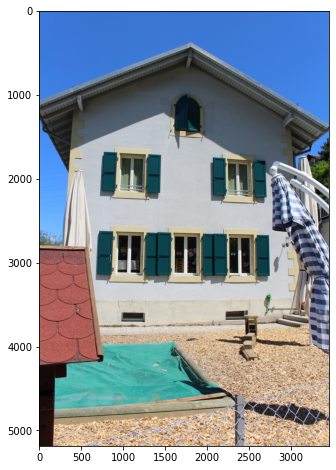

In [62]:
plt.figure(figsize=(8, 8))
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 语义分割预测

In [63]:
result = inference_model(model, img_bgr)

In [64]:
result.keys()

['seg_logits', 'pred_sem_seg']

In [65]:
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

In [66]:
pred_mask.shape

(5184, 3456)

In [67]:
np.unique(pred_mask)

array([0, 1])

## 语义分割预测结果-定性

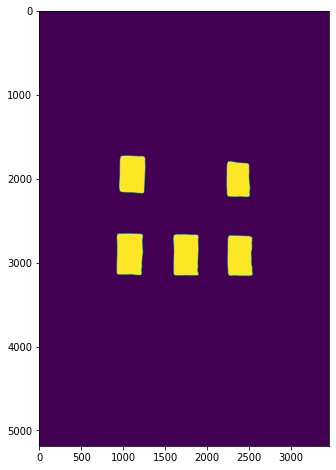

In [68]:
plt.figure(figsize=(8, 8))
plt.imshow(pred_mask)
plt.savefig('outputs/0513.jpg')
plt.show()

## 语义分割预测结果-定量

In [69]:
result.seg_logits.data.shape

torch.Size([2, 5184, 3456])

## 可视化语义分割预测结果-方法一

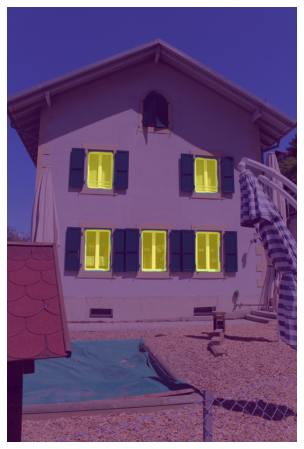

In [70]:
# 显示语义分割结果
plt.figure(figsize=(10, 8))
plt.imshow(img_bgr[:,:,::-1])
plt.imshow(pred_mask, alpha=0.55) # alpha 高亮区域透明度，越小越接近原图
plt.axis('off')
plt.savefig('outputs/0513-1.jpg')
plt.show()

## 可视化语义分割预测结果-方法二（和原图并排显示）

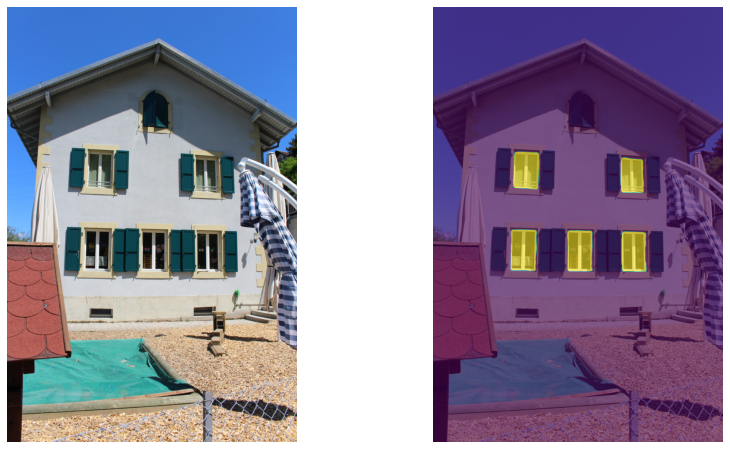

In [71]:
plt.figure(figsize=(14, 8))

plt.subplot(1,2,1)
plt.imshow(img_bgr[:,:,::-1])
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_bgr[:,:,::-1])
plt.imshow(pred_mask, alpha=0.6) # alpha 高亮区域透明度，越小越接近原图
plt.axis('off')
plt.savefig('outputs/0513-2.jpg')
plt.show()

## 可视化语义分割预测结果-方法三（按配色方案叠加在原图上显示）

In [25]:
# 各类别的配色方案（BGR）
palette = [
    ['background', [127,127,127]],
    ['red', [0,0,200]],
    ]

palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

In [26]:
palette_dict

{0: [127, 127, 127], 1: [0, 0, 200]}

In [27]:
opacity = 0.3 # 透明度，越大越接近原图

In [28]:
# 将预测的整数ID，映射为对应类别的颜色
pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
for idx in palette_dict.keys():
    pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
pred_mask_bgr = pred_mask_bgr.astype('uint8')

# 将语义分割预测图和原图叠加显示
pred_viz = cv2.addWeighted(img_bgr, opacity, pred_mask_bgr, 1-opacity, 0)

cv2.imwrite('outputs/K1-3.jpg', pred_viz)

True

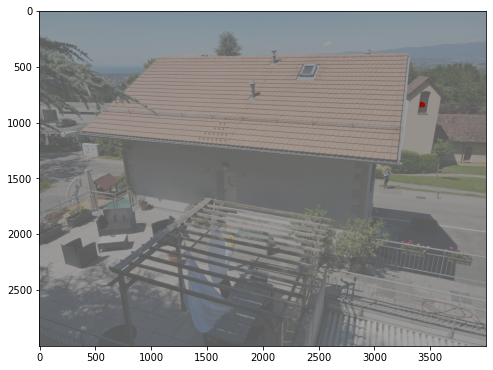

In [29]:
plt.figure(figsize=(8, 8))
plt.imshow(pred_viz[:,:,::-1])
plt.show()

## 可视化语义分割预测结果-方法三

按照`mmseg/datasets/ZihaoDataset.py`里定义的类别颜色可视化

In [30]:
from mmseg.apis import show_result_pyplot

In [32]:
img_viz = show_result_pyplot(model, img_path, result, opacity=0.8, title='MMSeg', out_file='outputs/K1-4.jpg')

opacity控制透明度，越小，越接近原图。

In [33]:
img_viz.shape

(3000, 4000, 3)

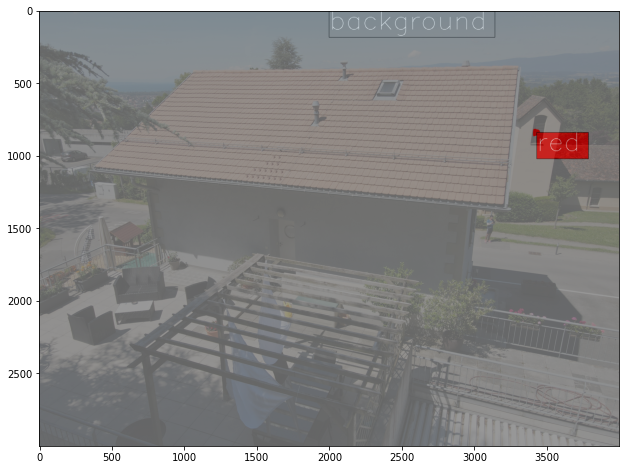

In [34]:
plt.figure(figsize=(14, 8))
plt.imshow(img_viz)
plt.show()

## 可视化语义分割预测结果-方法四（加图例）

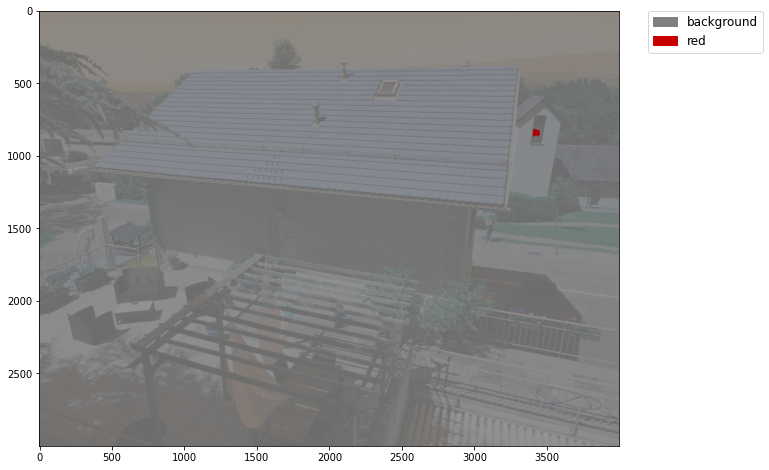

In [35]:
from mmseg.datasets import windowcolor
import numpy as np
import mmcv 
from PIL import Image

# 获取类别名和调色板
classes = windowcolor.METAINFO['classes']
palette = windowcolor.METAINFO['palette']
opacity = 0.15 # 透明度，越大越接近原图

# 将分割图按调色板染色
# seg_map = result[0].astype('uint8')
seg_map = pred_mask.astype('uint8')
seg_img = Image.fromarray(seg_map).convert('P')
seg_img.putpalette(np.array(palette, dtype=np.uint8))

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
plt.figure(figsize=(14, 8))
img_plot = ((np.array(seg_img.convert('RGB')))*(1-opacity) + mmcv.imread(img_path)*opacity) / 255
im = plt.imshow(img_plot)

# 为每一种颜色创建一个图例
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(len(classes))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.savefig('outputs/K1-6.jpg')
plt.show()